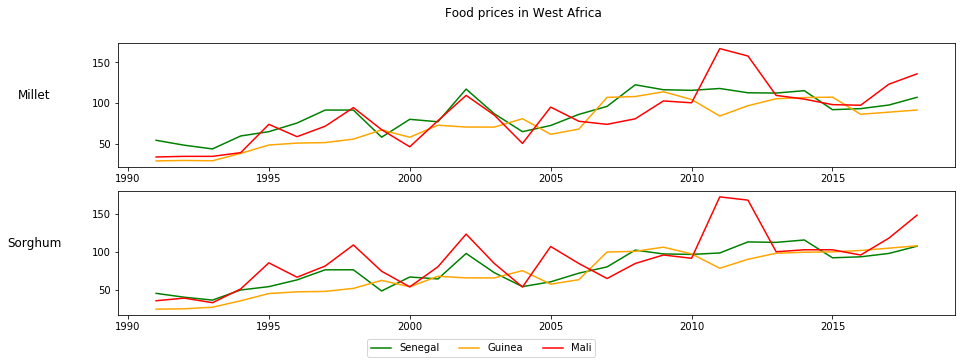

In [1]:

from pathlib import Path
import zipfile
import pandas as pd
import numpy as np
import numbers
import re
%matplotlib inline
import matplotlib.pyplot as plt

home = str(Path.home())

zip_file = home + '/Prices_E_Africa.zip'

# unzip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(home)
    
price_data_file = home + '/Prices_E_Africa.csv'

# read data
data_raw = pd.read_csv(price_data_file, encoding = "ISO-8859-1")

# select data
list_countries = data_raw.Area.unique()
list_countries_selected = ['Mauritania', 'Mali', 'Senegal', 'Guinea']

list_products = sorted(data_raw.Item.unique())
list_products_selected = ['Sorghum', 'Millet']

list_dates = data_raw.Months.unique()
list_dates_selected = ['Annual value']

list_variables = data_raw.Element.unique()
list_variables_selected = ['Producer Price Index (2014-2016 = 100)']

data = data_raw[
        (data_raw.Area.isin(list_countries_selected)) &
        (data_raw.Item.isin(list_products_selected)) &
        (data_raw.Months.isin(list_dates_selected)) &
        (data_raw.Element.isin(list_variables_selected))
        ]

id_vars = ['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element',
       'Months Code', 'Months', 'Unit']

list_other_col = [col for col in data.columns if col not in id_vars]

# pivot data
data = pd.melt(data, id_vars = id_vars, value_vars = list_other_col)

# keep numeric values and drop na
val_numeric = [isinstance(x, numbers.Number) for x in data.value]
data = data[val_numeric]
data = data.dropna(subset = {'value'})

# clean year column
def clean_year(string):
    re_searched = re.search('^Y.*$', string)
    if re_searched:
        string_found = re_searched.group(0)
        string_found_cleaned = string_found.replace("Y", "")
    else:
        string_found_cleaned = string
    return(string_found_cleaned)
    
data['year'] = data.variable.apply(clean_year)
data['year'] = pd.to_numeric(data['year'])


conditions = [data.Area == "Mauritania", data.Area == "Mali",
              data.Area == "Senegal", data.Area == "Guinea"]
values = ["blue", "red", "green", "orange"]

data['color'] = np.select(conditions, values)

# plot
n_products = len(list_products_selected)

fig, axes = plt.subplots(n_products,1, figsize=(15,5))
plt.suptitle("Food prices in West Africa")

for (product, group), ax in zip(data.groupby('Item'), axes.flatten()):
    for (country, group2) in group.groupby(['color', 'Area']):
        group2.plot(x='year', y='value',
                    kind='line', ax=ax,
                    color = country[0], label = country[1],
                    legend=False).xaxis.label.set_visible(False)
        ax.set_title(product, x=-0.1,y=0.5)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)
